In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 
pd.set_option('display.max_columns', 5000)

# pretty pictures
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2022/players.csv
/kaggle/input/nfl-big-data-bowl-2022/PFFScoutingData.csv
/kaggle/input/nfl-big-data-bowl-2022/tracking2019.csv
/kaggle/input/nfl-big-data-bowl-2022/tracking2020.csv
/kaggle/input/nfl-big-data-bowl-2022/games.csv
/kaggle/input/nfl-big-data-bowl-2022/tracking2018.csv
/kaggle/input/nfl-big-data-bowl-2022/plays.csv


# [NFL BDB](https://www.kaggle.com/c/nfl-big-data-bowl-2022/overview)

### Predicting Penalties on Punts and Kickoffs

This notebook is meant as an exploration of the NFL Bid Data Bowl data, as well as some general interest feature engineering and building basic classification models. It's purpose isn't to generate a useful model but more for my own Data Science interest and practice. 

The main focus here is feature engineering using four of the NFL's special teams datasets, and using the engineered data to build a model that can predict whether or not a punt or a kickoff will result in a penalty. Of course, most plays *don't* result in a penalty, so as shown below, the models that get built will all be very good at predicting the plays without penalties, but not so good at predicting the plays that *do* result in penalties. Also, the model can't predict *which* team will get a penalty. 

Like I said, this isn't meant to be a useful model (yet?).

[Part 1:](#part1) Data Exploration and Feature Engineering

[Part 2:](#modelling) Modelling

In [2]:
# get the data
scouting_data = pd.read_csv("../input/nfl-big-data-bowl-2022/PFFScoutingData.csv")
games = pd.read_csv("../input/nfl-big-data-bowl-2022/games.csv")
players = pd.read_csv("../input/nfl-big-data-bowl-2022/players.csv")
plays = pd.read_csv("../input/nfl-big-data-bowl-2022/plays.csv")

# Part 1: Data Exploration and Feature Engineering 
* [Games](#games-data)
* [Plays](#plays-data-nav)
* [Scouting](#scouting-data)

<a id="games-data"></a>
## Games Data
The Games dataset is the smallest dataset and very straightforward. 
* gameID is a primary key for joins
* having gameDate and the week number may be redundant
* gameTime will be changed to afternoon, evening, night

In [3]:
games

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN
...,...,...,...,...,...,...,...
759,2021010311,2020,17,01/03/2021,16:25:00,DEN,LV
760,2021010312,2020,17,01/03/2021,16:25:00,HOU,TEN
761,2021010313,2020,17,01/03/2021,16:25:00,IND,JAX
762,2021010314,2020,17,01/03/2021,16:25:00,LA,ARI


In [4]:
games['gameTimeEastern'].value_counts()

13:00:00    403
16:25:00    119
20:20:00     95
16:05:00     71
20:15:00     47
16:30:00      9
09:30:00      4
19:10:00      3
22:20:00      3
12:30:00      3
17:00:00      2
21:00:00      1
19:05:00      1
19:00:00      1
15:40:00      1
20:05:00      1
Name: gameTimeEastern, dtype: int64

In [5]:
def categorize_start_time(hour):
    if int(hour)<16:
        return 'A'  # afternoon                       
    elif int(hour)>=16 and int(hour)<19:
        return 'E'  # evening
    else:
        return 'N'  # night

In [6]:
def process_games(games_df):
    # make a working copy
    df = games_df.copy()
    
    # add a startPeriod column
    df['startHour'] = games['gameTimeEastern'].str[0:2]
    df['startPeriod'] = df['startHour'].map(lambda x: categorize_start_time(x))
        
    # remove the unnecessary ones
    df = df.drop(['startHour', 'gameTimeEastern'], axis=1)
    
    return df

In [7]:
process_games(games)

,gameId,season,week,gameDate,homeTeamAbbr,visitorTeamAbbr,startPeriod
0,2018090600,2018,1,09/06/2018,PHI,ATL,N
1,2018090900,2018,1,09/09/2018,BAL,BUF,A
2,2018090901,2018,1,09/09/2018,CLE,PIT,A
3,2018090902,2018,1,09/09/2018,IND,CIN,A
4,2018090903,2018,1,09/09/2018,MIA,TEN,A
...,...,...,...,...,...,...,...
759,2021010311,2020,17,01/03/2021,DEN,LV,E
760,2021010312,2020,17,01/03/2021,HOU,TEN,E
761,2021010313,2020,17,01/03/2021,IND,JAX,E
762,2021010314,2020,17,01/03/2021,LA,ARI,E


<a id="plays-data-nav"></a>
## Plays Data

Much more interesting. The field descriptions are from the [competition data page](https://www.kaggle.com/c/nfl-big-data-bowl-2022/data).

* **gameId**: Game identifier, unique (numeric)
* **playId**: Play identifier, not unique across games (numeric)
* **playDescription**: Description of play (text)
* **quarter**: Game quarter (numeric)
* **down**: Down (numeric)
* **yardsToGo**: Distance needed for a first down (numeric)
* **possessionTeam**: Team punting, placekicking or kicking off the ball (text)
* **specialTeamsPlayType**: Formation of play: Extra Point, Field Goal, Kickoff or Punt (text)
* **specialTeamsPlayResult**: Special Teams outcome of play dependent on play type: Blocked Kick Attempt, Blocked Punt, Downed, Fair Catch, Kick Attempt Good, Kick Attempt No Good, Kickoff Team Recovery, Muffed, Non-Special Teams Result, Out of Bounds, Return or Touchback (text)
* **kickerId**: nflId of placekicker, punter or kickoff specialist on play (numeric)
* **returnerId**: nflId(s) of returner(s) on play if there was a special teams return. Multiple returners on a play are separated by a ; (text)
* **kickBlockerId**: nflId of blocker of kick on play if there was a blocked field goal or blocked punt (numeric)
* **yardlineSide**: 3-letter team code corresponding to line-of-scrimmage (text)
* **yardlineNumber**: Yard line at line-of-scrimmage (numeric)
* **gameClock**: Time on clock of play (MM:SS)
* **penaltyCodes**: NFL categorization of the penalties that occurred on the play. Multiple penalties on a play are separated by a ; (text)
* **penaltyJerseyNumbe**r: Jersey number and team code of the player committing each penalty. Multiple penalties on a play are separated by a ; (text)
* **penaltyYards**: yards gained by possessionTeam by penalty (numeric)
* **preSnapHomeScore**: Home score prior to the play (numeric)
* **preSnapVisitorScore**: Visiting team score prior to the play (numeric)
* **passResult**: Scrimmage outcome of the play if specialTeamsPlayResult is "Non-Special Teams Result" (C: Complete pass, I: Incomplete pass, S: Quarterback sack, IN: Intercepted pass, R: Scramble, ' ': Designed Rush, text)
* **kickLength**: Kick length in air of kickoff, field goal or punt (numeric)
* **kickReturnYardage**: Yards gained by return team if there was a return on a kickoff or punt (numeric)
* **playResult**: Net yards gained by the kicking team, including penalty yardage (numeric)
* **absoluteYardlineNumber**: Location of ball downfield in tracking data coordinates (numeric)

In [8]:
plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,NaN,NaN,PHI,35,15:00:00,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,NaN,NaN,PHI,3,05:03:00,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,44979,NaN,ATL,35,05:01:00,NaN,NaN,NaN,0,3,NaN,64.0,30.0,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,NaN,NaN,PHI,35,00:33:00,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,2021010315,3683,J.Myers kicks 65 yards from SEA 35 to end zone...,4,0,0,SEA,Kickoff,Touchback,41175.0,NaN,NaN,SEA,35,02:20:00,NaN,NaN,NaN,16,19,NaN,75.0,NaN,40,75
19975,2021010315,3870,"J.Myers extra point is GOOD, Center-T.Ott, Hol...",4,0,0,SEA,Extra Point,Kick Attempt Good,41175.0,NaN,NaN,SF,15,01:49:00,NaN,NaN,NaN,16,25,NaN,NaN,NaN,0,25
19976,2021010315,3886,J.Myers kicks 65 yards from SEA 35 to end zone...,4,0,0,SEA,Kickoff,Touchback,41175.0,NaN,NaN,SEA,35,01:49:00,NaN,NaN,NaN,16,26,NaN,75.0,NaN,40,75
19977,2021010315,4166,"T.Vizcaino extra point is GOOD, Center-C.Holba...",4,0,0,SF,Extra Point,Kick Attempt Good,47590.0,NaN,NaN,SEA,15,00:23:00,NaN,NaN,NaN,22,26,NaN,NaN,NaN,0,95


<a id="plays-data-nav"></a>
### Plays Data Feature Engineering

My Goal here is to predict whether or not there will be a penalty, so first we're going to add a penalty flag column (no pun intended). I'm also looking only at penalties on kickoffs and punts, so I'll filter out other plays.
I'm going to get rid of some of these columns:
* The playID and gameID are going to stay in order to join the other data sets
* penaltyYards, penaltyCodes, and penaltyJerseyNumbers have to go because they will obviously match up to perfectly to the penaltyFlag column, which I'm trying to predict. This is to avoid leakage. 
* Kickoffs don't have a down and every single punt happened on fourth down, so I'll get rid of the down column
* I need to test whether absoluteYardlineNumber measures from one team's end or a stadium-specific end [(see below)](#yardline).
* I'm going to assume that who the kicker or returner is has no bearing on whether or not there was a penalty and get rid of the kickerId  and returnerId column; this is justifiable because I will be including data about each specific kick. I did a brief examination [below](#kickers-returners) but some kickers and returners have been involved with plays with a large amount of penalties. (Note: I'm going to do an exploration on which kickers and returners have been involved with the most plays with penalties. It's not done yet but I am going to link to it [here]()).
* Going to use quarter as a proxy for the time and get rid of the gameClock column.
* Such a small quantity of non-Nan's in the passResult column that I'm just going to remove it.

In addition. the returnYardage column has a bunch of NaN values, that I'll replace with 0. 

The [special teams result](#specialTeamResult) column seems to a somewhat valuable predictor, so it will be kept and one-hot encoded. Some of the encoding of categorical features will need to be done after the dataset is split between kickoffs and punts, and some before. Click [here](#encoding) to jump to the encoding section.

Next, I'm going to split the data into kickoffs and punts, as there are differences between them that should be handled. Click [here](#split) to jump to this section.

In [9]:
def kick_punt_filter(specialTeamsPlayType):
    """Used in a map/lambda to get rid of records other than those referring to a kickoff or a punt"""
    
    if specialTeamsPlayType == "Kickoff" or specialTeamsPlayType=="Punt":
        return specialTeamsPlayType
    else:
        return False

In [10]:
def process_plays(plays_df):
    """Takes in the original plays DataFrame and returns the processed one."""
    
    df = plays_df.copy()
    
    # add penalty flag column
    df['penaltyFlag'] = df['penaltyCodes'].notnull().astype(int)
    
    # filter for kickoffs and punts
    df['kickType'] = df['specialTeamsPlayType'].map(lambda x: kick_punt_filter(x))
    df = df.drop('specialTeamsPlayType', axis=1)
    
    df = df[df.kickType != False]
    
    # add in the yardsFromEndzone column
    # the reasoning is described in the Yard Line section below
    yardsFromEndzone = df['yardlineSide'] == df['possessionTeam']
    df['yardsFromEndzone'] = np.where(yardsFromEndzone, df['yardlineNumber'], 100-df['yardlineNumber']) 
    
    # fill NaN's
    df['kickReturnYardage'].fillna(0, inplace=True)
    df['penaltyYards'].fillna(0, inplace=True)
    df['penaltyJerseyNumbers'].fillna('None', inplace=True)
    
    # combine playId and gameId into a single column
    # this will be used later to join with the scouting data
    df['gameId'] = df['gameId'].astype(str)
    df['playId'] = df['playId'].astype(str)
    df['play_key'] = df[['gameId', 'playId']].agg('-'.join, axis=1)
    
    # drop unnecessary columns
    df = df.drop(['gameId',
                  'playId',
                  'penaltyYards',
                  'playDescription',
                  'absoluteYardlineNumber',
                  'down',
                  'gameClock',
                  'passResult',
                  'yardlineSide',
                  'yardlineNumber',
                  'kickerId',
                  'returnerId',
                  'kickBlockerId',
                  'penaltyCodes',
                  'penaltyJerseyNumbers'],
                 axis=1)
    
    
    return df

In [11]:
process_plays(plays)

,quarter,yardsToGo,possessionTeam,specialTeamsResult,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,kickType,yardsFromEndzone,play_key
0,1,0,PHI,Touchback,0,0,66.0,0.0,40,0,Kickoff,35,2018090600-37
1,1,4,PHI,Return,0,0,56.0,5.0,36,1,Punt,8,2018090600-366
3,1,0,ATL,Return,0,3,64.0,30.0,34,0,Kickoff,35,2018090600-677
4,1,18,PHI,Touchback,0,3,65.0,0.0,45,0,Punt,35,2018090600-872
5,2,19,ATL,Fair Catch,0,3,49.0,0.0,49,0,Punt,11,2018090600-973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19971,4,0,SEA,Return,16,12,63.0,18.0,45,0,Kickoff,35,2021010315-3105
19972,4,5,SF,Fair Catch,16,12,44.0,0.0,44,0,Punt,41,2021010315-3258
19974,4,0,SEA,Touchback,16,19,75.0,0.0,40,0,Kickoff,35,2021010315-3683
19976,4,0,SEA,Touchback,16,26,75.0,0.0,40,0,Kickoff,35,2021010315-3886


<a id="yardline"></a>
#### Yard Line 

The next code block will test whether **absoluteYardlineNumber** is fixed from one team's end (e.g. yards from the home team's end zone) or fixed from one end of the stadium (e.g. yards from the south end zone, regardless of which team's that is). We'll have to make subset DataFrames from the relevant columns in the games and the plays df's and then join them on **gameId**. 

From inspecting the first few rows, it's obvious that **absoluteYardlineNumber** measures from a fixed end in the stadium.  In the first quarter of the Philadelphia-Atlanta game (seen below, gameId=201809600), **absoluteYardlineNumber** measures from Philadelphia's end. When the two teams switch sides in the second quarter, it measures from Atlanta's end. This means we can get rid of the the **absoluteYardline** column and use only **yardlineSide** and **yardlineNumber**.

[Back to Plays Data Navigator](#plays-data-nav)


In [12]:
def test_yardline(plays, games):
    # relevant columns from the two dfs:
    yardlineTestDf1 = plays[['gameId','absoluteYardlineNumber', 'yardlineSide', 'yardlineNumber', 'quarter', 'possessionTeam']]
    yardlineTestDf2 = games[['gameId', 'homeTeamAbbr']]
    
    # join them
    yardlineTestDF = yardlineTestDf1.set_index('gameId').join(yardlineTestDf2.set_index('gameId'))
    
    return yardlineTestDF

In [13]:
test_yardline(plays, games).head(10)

,absoluteYardlineNumber,yardlineSide,yardlineNumber,quarter,possessionTeam,homeTeamAbbr
gameId,,,,,,
2018090600,45,PHI,35,1,PHI,PHI
2018090600,18,PHI,8,1,PHI,PHI
2018090600,13,PHI,3,1,ATL,PHI
2018090600,75,ATL,35,1,ATL,PHI
2018090600,45,PHI,35,1,PHI,PHI
2018090600,21,ATL,11,2,ATL,PHI
2018090600,18,ATL,8,2,PHI,PHI
2018090600,75,PHI,35,2,PHI,PHI
2018090600,76,PHI,34,2,ATL,PHI


Now that we've got that, what we want to do is turn the yardlineSide and yardlineNumber features into a single one called yardsFromEndzone, which denotes where the line of scrimmage is from one's own endzone. This will be yardline number if yardlineSide = possessionTeam, if not, it'll be the yardlineNumber subtracted from 100, since the other team's 5 yard line and 25 yard line are 95 and 75 yards from one's own endzone.

This functionality is implemented within the process_plays() function above.

<a id="specialTeamResult"></a>
#### Special Teams Result
Next, I'm going to do some general exploring of other features and decide whether or not to keep them, based on whether there's any indication of those correlating with there being a penalty. The **specialTeamsResult** column definitely looks like it should be kept.

[Back to Plays Data Navigator](#plays-data-nav)

In [14]:
process_plays(plays)['specialTeamsResult'].value_counts()

Return                      5207
Touchback                   5156
Fair Catch                  1645
Downed                       833
Out of Bounds                650
Muffed                       214
Non-Special Teams Result      74
Blocked Punt                  39
Kickoff Team Recovery         16
Name: specialTeamsResult, dtype: int64

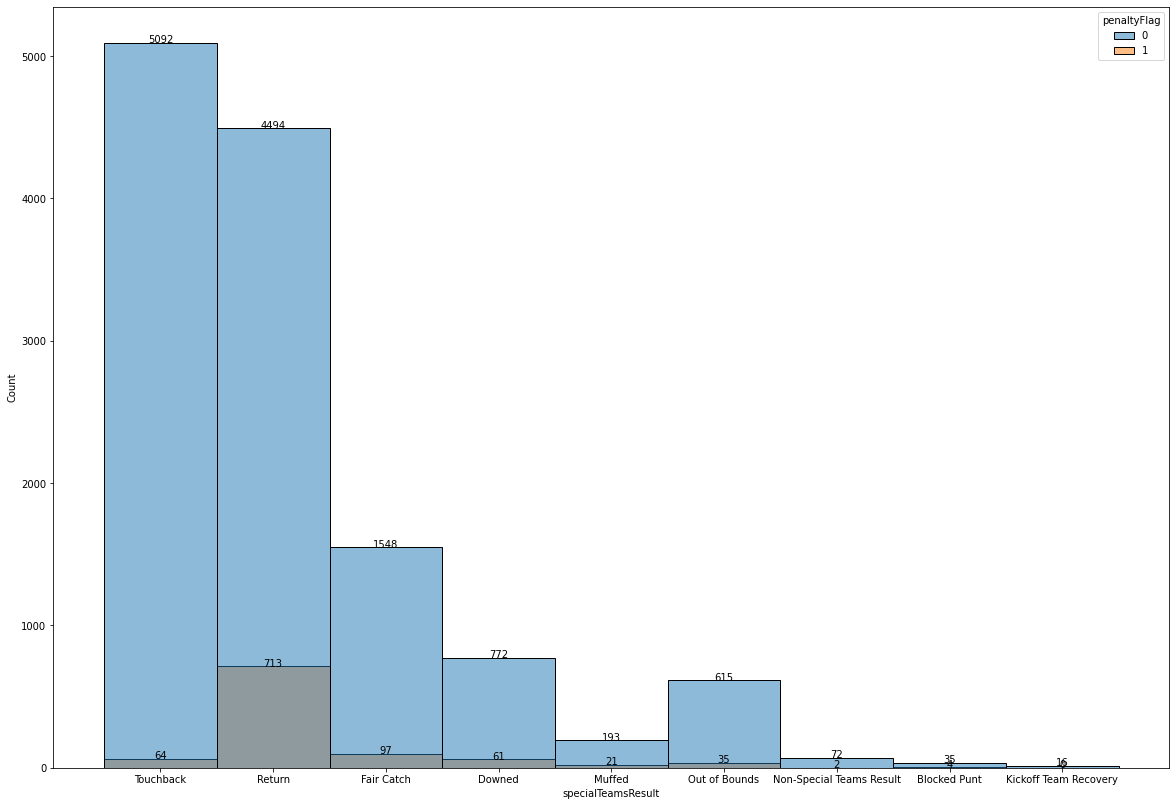

In [15]:
plt.figure(figsize=(20,14))
graph = sns.histplot(process_plays(plays), x=process_plays(plays)['specialTeamsResult'], hue=process_plays(plays)['penaltyFlag'], stat='count')
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.3, height, ha="center")
plt.show()

In [16]:
process_plays(plays)

,quarter,yardsToGo,possessionTeam,specialTeamsResult,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,kickType,yardsFromEndzone,play_key
0,1,0,PHI,Touchback,0,0,66.0,0.0,40,0,Kickoff,35,2018090600-37
1,1,4,PHI,Return,0,0,56.0,5.0,36,1,Punt,8,2018090600-366
3,1,0,ATL,Return,0,3,64.0,30.0,34,0,Kickoff,35,2018090600-677
4,1,18,PHI,Touchback,0,3,65.0,0.0,45,0,Punt,35,2018090600-872
5,2,19,ATL,Fair Catch,0,3,49.0,0.0,49,0,Punt,11,2018090600-973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19971,4,0,SEA,Return,16,12,63.0,18.0,45,0,Kickoff,35,2021010315-3105
19972,4,5,SF,Fair Catch,16,12,44.0,0.0,44,0,Punt,41,2021010315-3258
19974,4,0,SEA,Touchback,16,19,75.0,0.0,40,0,Kickoff,35,2021010315-3683
19976,4,0,SEA,Touchback,16,26,75.0,0.0,40,0,Kickoff,35,2021010315-3886


In [17]:
# only a few non-nan passResult
plays['passResult'].value_counts()

C     23
I     17
S      3
IN     2
Name: passResult, dtype: int64

<a id=kickers-returners></a>
What about keeping the kicker or returner? Let's sum up the number of penalties for each.
#### Kickers and Returners
For some reason, a few kickers have a huge number of penalties resulting from their kicks. This will be explored elsewhere and I'll link to it here when it's done. A surface level examination is below; click here to skip to below it. For example, we can see below that kicker 40113's kicks had 45 penalties; the average was 9.3 (red line) and the median was 8 (yellow line).

The situation for returners is similar.

For the time being, I'm going to assume the identity of the kicker or returner is irrelevant and remove it.

[Back to Plays Data Navigator](#plays-data-nav)

In [18]:
def whatsup_with_the_kickers(plays_df):
    """Takes in the original plays DataFrame and returns the processed one."""
    
    df = plays_df.copy()
    
    # add penalty flag column
    df['penaltyFlag'] = df['penaltyCodes'].notnull().astype(int)
    
    kickers = df[['kickerId', 'penaltyFlag']]
    kickers = kickers.groupby(['kickerId']).sum().sort_values('penaltyFlag', ascending=False)
    kickers = kickers.reset_index()
    
    # plot the penalties for each kicker
    plt.figure(figsize=(14,10))
    ax = sns.barplot(x=kickers.index, y=kickers["penaltyFlag"])
    # horizontal lines for median, mean
    ax.axhline(kickers.describe().loc['mean','penaltyFlag'], color='red')
    ax.axhline(kickers.describe().loc['50%','penaltyFlag'], color='yellow')
    ax.set_xticklabels(kickers.kickerId)
    for item in ax.get_xticklabels(): item.set_rotation(90)
    plt.show()
    
    
    return kickers, kickers.describe()['penaltyFlag'], kickers.describe().loc['50%','penaltyFlag']

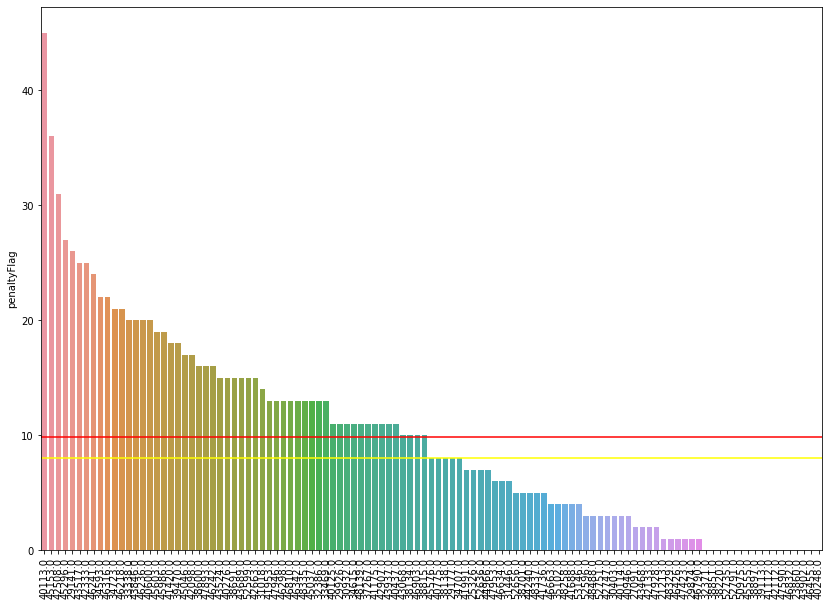

(     kickerId  penaltyFlag
 0     40113.0           45
 1     45153.0           36
 2     42508.0           31
 3     45296.0           27
 4     29141.0           26
 ..        ...          ...
 106   46832.0            0
 107   23860.0            0
 108   43902.0            0
 109   46455.0            0
 110   40248.0            0
 
 [111 rows x 2 columns],
 count    111.000000
 mean       9.891892
 std        8.743155
 min        0.000000
 25%        3.000000
 50%        8.000000
 75%       15.000000
 max       45.000000
 Name: penaltyFlag, dtype: float64,
 8.0)

In [19]:
whatsup_with_the_kickers(plays)

<a id=encoding></a>
### Encoding
I'm going to define a general one-hot encoding function that will take in a dataframe, the column to encode, and a prefix and return a new Dataframe with the column encoded.

[Back to Plays Data Navigator](#plays-data-nav)

In [20]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df,dummies],axis=1)
    df = df.drop(column, axis=1)
    
    return df

In [21]:
process_plays(plays)

,quarter,yardsToGo,possessionTeam,specialTeamsResult,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,kickType,yardsFromEndzone,play_key
0,1,0,PHI,Touchback,0,0,66.0,0.0,40,0,Kickoff,35,2018090600-37
1,1,4,PHI,Return,0,0,56.0,5.0,36,1,Punt,8,2018090600-366
3,1,0,ATL,Return,0,3,64.0,30.0,34,0,Kickoff,35,2018090600-677
4,1,18,PHI,Touchback,0,3,65.0,0.0,45,0,Punt,35,2018090600-872
5,2,19,ATL,Fair Catch,0,3,49.0,0.0,49,0,Punt,11,2018090600-973
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19971,4,0,SEA,Return,16,12,63.0,18.0,45,0,Kickoff,35,2021010315-3105
19972,4,5,SF,Fair Catch,16,12,44.0,0.0,44,0,Punt,41,2021010315-3258
19974,4,0,SEA,Touchback,16,19,75.0,0.0,40,0,Kickoff,35,2021010315-3683
19976,4,0,SEA,Touchback,16,26,75.0,0.0,40,0,Kickoff,35,2021010315-3886


In [22]:
plays_data = onehot_encode(process_plays(plays), 'possessionTeam', 'team')
plays_data

,quarter,yardsToGo,specialTeamsResult,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,kickType,yardsFromEndzone,play_key,team_ARI,team_ATL,team_BAL,team_BUF,team_CAR,team_CHI,team_CIN,team_CLE,team_DAL,team_DEN,team_DET,team_GB,team_HOU,team_IND,team_JAX,team_KC,team_LA,team_LAC,team_LV,team_MIA,team_MIN,team_NE,team_NO,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS
0,1,0,Touchback,0,0,66.0,0.0,40,0,Kickoff,35,2018090600-37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,4,Return,0,0,56.0,5.0,36,1,Punt,8,2018090600-366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0,Return,0,3,64.0,30.0,34,0,Kickoff,35,2018090600-677,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,18,Touchback,0,3,65.0,0.0,45,0,Punt,35,2018090600-872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,2,19,Fair Catch,0,3,49.0,0.0,49,0,Punt,11,2018090600-973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19971,4,0,Return,16,12,63.0,18.0,45,0,Kickoff,35,2021010315-3105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
19972,4,5,Fair Catch,16,12,44.0,0.0,44,0,Punt,41,2021010315-3258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
19974,4,0,Touchback,16,19,75.0,0.0,40,0,Kickoff,35,2021010315-3683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
19976,4,0,Touchback,16,26,75.0,0.0,40,0,Kickoff,35,2021010315-3886,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


<a id="scouting-data"></a>
## Scouting Data

The third and final dataset we'll bring in is the PFF scouting data. Here are the field definitions from the NFL:

* **gameId**: Game identifier, unique (numeric)
* **playId**: Play identifier, not unique across games (numeric)
* **snapDetail**: On Punts, whether the snap was on target and if not, provides detail (H: High, L: Low, <: Left, >: Right, OK: Accurate Snap, text)
* **operationTime**: Timing from snap to kick on punt plays in seconds: (numeric)
* **hangTime**: Hangtime of player's punt or kickoff attempt in seconds. Timing is taken from impact with foot to impact with the ground or a player. (numeric)
* **kickType**: Kickoff or Punt Type (text).
* * Possible values for kickoff plays:
* * * D: Deep - your normal deep kick with decent hang time
* * * F: Flat - different than a Squib in that it will have some hang time and no roll but has a lower trajectory and hang time than a Deep kick off
* * * K: Free Kick - Kick after a safety
* * * O: Obvious Onside - score and situation dictates the need to regain possession. Also the hands team is on for the returning team
* * * P: Pooch kick - high for hangtime but not a lot of distance - usually targeting an upman
* * * Q: Squib - low-line drive kick that bounces or rolls considerably, with virtually no hang time
* * * S: Surprise Onside - accounting for score and situation an onsides kick that the returning team doesn’t expect. Hands teams probably aren't on the field
* * * B: Deep Direct OOB - Kickoff that is aimed deep (regular kickoff) that goes OOB directly (doesn't bounce)
* * Possible values for punt plays:
* * * N: Normal - standard punt style
* * * R: Rugby style punt
* * * A: Nose down or Aussie-style punts
* **kickDirectionIntended**: Intended kick direction from the kicking team's perspective - based on how coverage unit sets up and other factors (L: Left, R: Right, C: Center, text).
* **kickDirectionActual**: Actual kick direction from the kicking team's perspective (L: Left, R: Right, C: Center, text).
* **returnDirectionIntended**: The return direction the punt return or kick off return unit is set up for from the return team's perspective (L: Left, R: Right, C: Center, text).
* **returnDirectionActual**: Actual return direction from the return team's perspective (L: Left, R: Right, C: Center, text).
* **missedTacklers**: Jersey number and team code of player(s) charged with a missed tackle on the play. It will be reasonable to assume that he should have brought down the ball carrier and failed to do so. This situation does not have to entail contact, but it most frequently does. Missed tackles on a QB by a pass rusher are also included here. Multiple missed tacklers on a play are separated by a ; (text).
* **assistTacklers**: Jersey number and team code of player(s) assisting on the tackle. Multiple assist tacklers on a play are separated by a ; (text).
* **tacklers**: Jersey number and team code of player making the tackle (text).
* **kickoffReturnFormation**: 3 digit code indicating the number of players in the Front Wall, Mid Wall and Back Wall (text).
* **gunners**: Jersey number and team code of player(s) lined up as gunner on punt unit. Multiple gunners on a play are separated by a ; (text).
* **puntRushers**: Jersey number and team code of player(s) on the punt return unit with "Punt Rush" role for actively trying to block the punt. Does not include players crossing the line of scrimmage to engage in punt coverage players in a "Hold Up" role. Multiple punt rushers on a play are separated by a ; (text).
* **specialTeamsSafeties**: Jersey number and team code for player(s) with "Safety" roles on kickoff coverage and field goal/extra point block units - and those not actively advancing towards the line of scrimmage on the punt return unit. Multiple special teams safeties on a play are separated by a ; (text).
* **vises**: Jersey number and team code for player(s) with a "Vise" role on the punt return unit. Multiple vises on a play are separated by a ; (text).
* **kickContactType**: Detail on how a punt was fielded, or what happened when it wasn't fielded (text).
* * Possible values:
* * * BB: Bounced Backwards
* * * BC: Bobbled Catch from Air
* * * BF: Bounced Forwards
* * * BOG: Bobbled on Ground
* * * CC: Clean Catch from Air
* * * CFFG: Clean Field From Ground
* * * DEZ: Direct to Endzone
* * * ICC: Incidental Coverage Team Contact
* * * KTB: Kick Team Knocked Back
* * * KTC: Kick Team Catch
* * * KTF: Kick Team Knocked Forward
* * * MBC: Muffed by Contact with Non-Designated Returner
* * * MBDR: Muffed by Designated Returner
* * * OOB: Directly Out Of Bounds

In [23]:
scouting_data

,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,missedTackler,assistTackler,tackler,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType
0,2018090600,37,NaN,NaN,NaN,3.85,D,R,R,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,PHI 23; PHI 27,NaN,NaN
1,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC
2,2018090600,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHI 58,NaN,NaN
3,2018090600,677,NaN,NaN,NaN,4.06,D,R,R,C,C,ATL 83,ATL 22,ATL 27,8-0-2,NaN,NaN,ATL 17; ATL 22,NaN,NaN
4,2018090600,872,OK,0.84,2.00,4.35,N,C,L,NaN,NaN,NaN,NaN,NaN,NaN,PHI 18; PHI 29,ATL 85,ATL 37,ATL 83; ATL 34; ATL 21,BF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,2021010315,3683,NaN,NaN,NaN,4.19,D,L,L,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,SEA 28; SEA 99,NaN,NaN
19975,2021010315,3870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SF 20; SF 51,NaN,NaN
19976,2021010315,3886,NaN,NaN,NaN,3.88,D,L,L,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,SEA 28; SEA 99,NaN,NaN
19977,2021010315,4166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEA 37; SEA 54,NaN,NaN


### Scouting Data Feature Engineering
* As with the plays data, the gameId and the playId will be merged to make a primary key 
* I'm going to get rid of the data about the tacklers
* Gunners, rushers, safeties, and vises will be turned into numeric values (simply the number of each)
* The times will stay as they are
* All of the other field are categorical and will get one hot encoded

The plays that aren't kickoffs or punts will be dropped when this data is inner-joined with the other data.


In [24]:
def process_scouting(df):
    df = df.copy()
    
    # rename kickType 
    df['typeOfKick'] = df['kickType']
    
    # change the player roles columns to the number of players occupying that role
    df['gunners'] = df['gunners'].map(lambda x: number_players(x))
    df['puntRushers'] = df['puntRushers'].map(lambda x: number_players(x))
    df['specialTeamsSafeties'] = df['specialTeamsSafeties'].map(lambda x: number_players(x))
    df['vises'] = df['vises'].map(lambda x: number_players(x))
    
    # combine playId and gameId into a single column
    df['gameId'] = df['gameId'].astype(str)
    df['playId'] = df['playId'].astype(str)
    df['play_key'] = df[['gameId', 'playId']].agg('-'.join, axis=1)
    
    # drop unnecessary columns
    df = df.drop(['gameId',
                  'playId',
                  'missedTackler',
                  'assistTackler',
                  'tackler',
                  'kickType'],
                 axis=1)
    
    return df

In [25]:
def number_players(players):
    """function to change the player roles columns to the number of players occupying that role"""
    if type(players) != str: # if it's not NaN
        return 0

      # if there are players who got penalties, we're just returning the number of semicolons + 1
    else:
        return players.count(';') + 1


In [26]:
process_scouting(scouting_data)

,snapDetail,snapTime,operationTime,hangTime,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType,typeOfKick,play_key
0,NaN,NaN,NaN,3.85,R,R,NaN,NaN,8-0-2,0,0,2,0,NaN,D,2018090600-37
1,OK,0.84,2.12,4.46,C,C,C,R,NaN,2,0,0,4,CC,N,2018090600-366
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,NaN,NaN,2018090600-658
3,NaN,NaN,NaN,4.06,R,R,C,C,8-0-2,0,0,2,0,NaN,D,2018090600-677
4,OK,0.84,2.00,4.35,C,L,NaN,NaN,NaN,2,1,1,3,BF,N,2018090600-872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19974,NaN,NaN,NaN,4.19,L,L,NaN,NaN,8-0-2,0,0,2,0,NaN,D,2021010315-3683
19975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2,0,NaN,NaN,2021010315-3870
19976,NaN,NaN,NaN,3.88,L,L,NaN,NaN,8-0-2,0,0,2,0,NaN,D,2021010315-3886
19977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2,0,NaN,NaN,2021010315-4166



## Merging and finalizing the two data sets 
Before we can go on any farther, the two datasets need to be merged - we get a 28 field dataset with nearly 14000 records.

In [27]:
full_data = process_plays(plays).set_index('play_key').join(process_scouting(scouting_data).set_index('play_key'))
full_data

,quarter,yardsToGo,possessionTeam,specialTeamsResult,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,kickType,yardsFromEndzone,snapDetail,snapTime,operationTime,hangTime,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType,typeOfKick
play_key,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600-37,1,0,PHI,Touchback,0,0,66.0,0.0,40,0,Kickoff,35,NaN,NaN,NaN,3.85,R,R,NaN,NaN,8-0-2,0,0,2,0,NaN,D
2018090600-366,1,4,PHI,Return,0,0,56.0,5.0,36,1,Punt,8,OK,0.84,2.12,4.46,C,C,C,R,NaN,2,0,0,4,CC,N
2018090600-677,1,0,ATL,Return,0,3,64.0,30.0,34,0,Kickoff,35,NaN,NaN,NaN,4.06,R,R,C,C,8-0-2,0,0,2,0,NaN,D
2018090600-872,1,18,PHI,Touchback,0,3,65.0,0.0,45,0,Punt,35,OK,0.84,2.00,4.35,C,L,NaN,NaN,NaN,2,1,1,3,BF,N
2018090600-973,2,19,ATL,Fair Catch,0,3,49.0,0.0,49,0,Punt,11,OK,0.86,2.19,4.98,L,L,NaN,NaN,NaN,2,4,0,2,CC,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021010315-3105,4,0,SEA,Return,16,12,63.0,18.0,45,0,Kickoff,35,NaN,NaN,NaN,4.28,L,L,R,R,8-0-2,0,0,2,0,NaN,D
2021010315-3258,4,5,SF,Fair Catch,16,12,44.0,0.0,44,0,Punt,41,OK,0.93,2.03,4.19,R,R,NaN,NaN,NaN,2,1,0,3,CC,A
2021010315-3683,4,0,SEA,Touchback,16,19,75.0,0.0,40,0,Kickoff,35,NaN,NaN,NaN,4.19,L,L,NaN,NaN,8-0-2,0,0,2,0,NaN,D


<a id=split></a>
### Splitting kickoffs and punts
Some of the fields are only for kickoffs, and some only for punts. Here I'll split them up before we move on.

* The fields only for punts are yardsToGo snapDetail, operationTime, hangTime, gunners, rushers, vises and kickContactType
* The field only for kickoffs is kickoffReturnFormation

In [28]:
kickoffs = full_data[full_data['kickType'] == 'Kickoff']
punts = full_data[full_data['kickType'] == 'Punt']

In [29]:
# check columns only for punts are all nans
# snapDetail, operationTime, snapTime, gunners, rushers, vises and kickContactType should all be 0
for column in kickoffs.columns:
    print(column + ' - '+ str(kickoffs[column].count()))

quarter - 7843
yardsToGo - 7843
possessionTeam - 7843
specialTeamsResult - 7843
preSnapHomeScore - 7843
preSnapVisitorScore - 7843
kickLength - 7843
kickReturnYardage - 7843
playResult - 7843
penaltyFlag - 7843
kickType - 7843
yardsFromEndzone - 7843
snapDetail - 0
snapTime - 0
operationTime - 0
hangTime - 7223
kickDirectionIntended - 7834
kickDirectionActual - 7834
returnDirectionIntended - 2821
returnDirectionActual - 2824
kickoffReturnFormation - 7843
gunners - 7843
puntRushers - 7843
specialTeamsSafeties - 7843
vises - 7843
kickContactType - 0
typeOfKick - 7843


In [30]:
for column in punts.columns:
    print(column + ' - '+ str(punts[column].count()))

quarter - 5991
yardsToGo - 5991
possessionTeam - 5991
specialTeamsResult - 5991
preSnapHomeScore - 5991
preSnapVisitorScore - 5991
kickLength - 5878
kickReturnYardage - 5991
playResult - 5991
penaltyFlag - 5991
kickType - 5991
yardsFromEndzone - 5991
snapDetail - 5917
snapTime - 5916
operationTime - 5916
hangTime - 5873
kickDirectionIntended - 5865
kickDirectionActual - 5865
returnDirectionIntended - 1933
returnDirectionActual - 1932
kickoffReturnFormation - 0
gunners - 5991
puntRushers - 5991
specialTeamsSafeties - 5991
vises - 5991
kickContactType - 5877
typeOfKick - 5878


<a id=kickoffs></a>
    
### Finishing up the kickoffs data

Last thing is to onehot encode the categorical columns and drop the unnecessary columns.

In [31]:
kickoffs

,quarter,yardsToGo,possessionTeam,specialTeamsResult,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,kickType,yardsFromEndzone,snapDetail,snapTime,operationTime,hangTime,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType,typeOfKick
play_key,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600-37,1,0,PHI,Touchback,0,0,66.0,0.0,40,0,Kickoff,35,NaN,NaN,NaN,3.85,R,R,NaN,NaN,8-0-2,0,0,2,0,NaN,D
2018090600-677,1,0,ATL,Return,0,3,64.0,30.0,34,0,Kickoff,35,NaN,NaN,NaN,4.06,R,R,C,C,8-0-2,0,0,2,0,NaN,D
2018090600-1387,2,0,PHI,Touchback,3,3,72.0,0.0,40,0,Kickoff,35,NaN,NaN,NaN,4.09,R,R,NaN,NaN,8-0-2,0,0,2,0,NaN,D
2018090600-1606,2,0,ATL,Return,3,6,68.0,13.0,60,1,Kickoff,35,NaN,NaN,NaN,3.63,C,C,C,R,8-0-2,0,0,2,0,NaN,D
2018090600-2225,3,0,ATL,Touchback,3,6,71.0,0.0,40,0,Kickoff,35,NaN,NaN,NaN,3.98,C,C,NaN,NaN,8-0-2,0,0,2,0,NaN,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021010315-2847,4,0,SF,Touchback,16,6,75.0,0.0,40,0,Kickoff,35,NaN,NaN,NaN,3.26,L,L,NaN,NaN,8-0-2,0,0,2,0,NaN,D
2021010315-3105,4,0,SEA,Return,16,12,63.0,18.0,45,0,Kickoff,35,NaN,NaN,NaN,4.28,L,L,R,R,8-0-2,0,0,2,0,NaN,D
2021010315-3683,4,0,SEA,Touchback,16,19,75.0,0.0,40,0,Kickoff,35,NaN,NaN,NaN,4.19,L,L,NaN,NaN,8-0-2,0,0,2,0,NaN,D


In [32]:
def process_kickoffs(df):
    df = df.copy()
    
    # drop unnecessary columns
    df = df.drop(['snapDetail',
                  'snapTime',
                  'yardsToGo',
                  'operationTime',
                  'gunners',
                  'puntRushers',
                  'vises',
                  'kickContactType',
                  'kickType']
                , axis=1)
    
    # onehot encoding
    df = onehot_encode(df, 'quarter', 'quarter')
    df = onehot_encode(df, 'possessionTeam', 'team')
    df = onehot_encode(df, 'specialTeamsResult', 'result')
    df = onehot_encode(df, 'kickDirectionIntended', 'kickDirectionIntended')
    df = onehot_encode(df, 'kickDirectionActual', 'kickDirectionActual')
    df = onehot_encode(df, 'returnDirectionIntended', 'returnDirectionIntended')
    df = onehot_encode(df, 'returnDirectionActual', 'returnDirectionActual')
    df = onehot_encode(df, 'kickoffReturnFormation', 'kickoffReturnFormation')
    df = onehot_encode(df, 'typeOfKick', 'typeOfKick')
    
    # deal with the NaN's in the hangTime Column
    df['hangTime'] = df['hangTime'].fillna(value=df['hangTime'].mean())
    
    return df



In [33]:
process_kickoffs(kickoffs)

,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,yardsFromEndzone,hangTime,specialTeamsSafeties,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,team_ARI,team_ATL,team_BAL,team_BUF,team_CAR,team_CHI,team_CIN,team_CLE,team_DAL,team_DEN,team_DET,team_GB,team_HOU,team_IND,team_JAX,team_KC,team_LA,team_LAC,team_LV,team_MIA,team_MIN,team_NE,team_NO,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,result_Downed,result_Fair Catch,result_Kickoff Team Recovery,result_Muffed,result_Out of Bounds,result_Return,result_Touchback,kickDirectionIntended_C,kickDirectionIntended_L,kickDirectionIntended_R,kickDirectionActual_C,kickDirectionActual_L,kickDirectionActual_R,returnDirectionIntended_C,returnDirectionIntended_L,returnDirectionIntended_R,returnDirectionActual_C,returnDirectionActual_L,returnDirectionActual_R,kickoffReturnFormation_10-0-0,kickoffReturnFormation_5-0-4,kickoffReturnFormation_5-3-2,kickoffReturnFormation_6-0-3,kickoffReturnFormation_6-0-4,kickoffReturnFormation_6-2-2,kickoffReturnFormation_7-0-3,kickoffReturnFormation_7-1-2,kickoffReturnFormation_8-0-1,kickoffReturnFormation_8-0-2,kickoffReturnFormation_8-0-3,kickoffReturnFormation_8-1-0,kickoffReturnFormation_8-1-1,kickoffReturnFormation_9-0-0,kickoffReturnFormation_9-0-1,kickoffReturnFormation_9-1-0,typeOfKick_B,typeOfKick_D,typeOfKick_F,typeOfKick_K,typeOfKick_O,typeOfKick_P,typeOfKick_Q,typeOfKick_S
play_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600-37,0,0,66.0,0.0,40,0,35,3.85000,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018090600-677,0,3,64.0,30.0,34,0,35,4.06000,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018090600-1387,3,3,72.0,0.0,40,0,35,4.09000,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018090600-1606,3,6,68.0,13.0,60,1,35,3.63000,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018090600-2225,3,6,71.0,0.0,40,0,35,3.98000,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021010315-2847,16,6,75.0,0.0,40,0,35,3.26000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2021010315-3105,16,12,63.0,18.0,45,0,35,4.28000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2021010315-3683,16,19,75.0,0.0,40,0,35,4.19000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


There are 620 NaN's in the hangTime field for kickoffs, which are simply missing randomly. They'll be filled with the average kickoff hangtime.

In [34]:
# the count() function counts the non-NaN's 
7843 - kickoffs['hangTime'].count()

620

In [35]:
# this should now be 7843
process_kickoffs(kickoffs)['hangTime'].count()

7843

In [36]:
# 620 were filled with the average value
process_kickoffs(kickoffs)['hangTime'].value_counts()

3.99399    620
4.11000    160
4.01000    153
4.03000    150
3.95000    150
          ... 
2.84000      1
4.96000      1
4.74000      1
5.00000      1
4.73000      1
Name: hangTime, Length: 204, dtype: int64

My final kickoffs data is below:

In [37]:
process_kickoffs(kickoffs)

,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,yardsFromEndzone,hangTime,specialTeamsSafeties,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,team_ARI,team_ATL,team_BAL,team_BUF,team_CAR,team_CHI,team_CIN,team_CLE,team_DAL,team_DEN,team_DET,team_GB,team_HOU,team_IND,team_JAX,team_KC,team_LA,team_LAC,team_LV,team_MIA,team_MIN,team_NE,team_NO,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,result_Downed,result_Fair Catch,result_Kickoff Team Recovery,result_Muffed,result_Out of Bounds,result_Return,result_Touchback,kickDirectionIntended_C,kickDirectionIntended_L,kickDirectionIntended_R,kickDirectionActual_C,kickDirectionActual_L,kickDirectionActual_R,returnDirectionIntended_C,returnDirectionIntended_L,returnDirectionIntended_R,returnDirectionActual_C,returnDirectionActual_L,returnDirectionActual_R,kickoffReturnFormation_10-0-0,kickoffReturnFormation_5-0-4,kickoffReturnFormation_5-3-2,kickoffReturnFormation_6-0-3,kickoffReturnFormation_6-0-4,kickoffReturnFormation_6-2-2,kickoffReturnFormation_7-0-3,kickoffReturnFormation_7-1-2,kickoffReturnFormation_8-0-1,kickoffReturnFormation_8-0-2,kickoffReturnFormation_8-0-3,kickoffReturnFormation_8-1-0,kickoffReturnFormation_8-1-1,kickoffReturnFormation_9-0-0,kickoffReturnFormation_9-0-1,kickoffReturnFormation_9-1-0,typeOfKick_B,typeOfKick_D,typeOfKick_F,typeOfKick_K,typeOfKick_O,typeOfKick_P,typeOfKick_Q,typeOfKick_S
play_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600-37,0,0,66.0,0.0,40,0,35,3.85000,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018090600-677,0,3,64.0,30.0,34,0,35,4.06000,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018090600-1387,3,3,72.0,0.0,40,0,35,4.09000,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018090600-1606,3,6,68.0,13.0,60,1,35,3.63000,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2018090600-2225,3,6,71.0,0.0,40,0,35,3.98000,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021010315-2847,16,6,75.0,0.0,40,0,35,3.26000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2021010315-3105,16,12,63.0,18.0,45,0,35,4.28000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2021010315-3683,16,19,75.0,0.0,40,0,35,4.19000,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [38]:
# quick null check
for col in process_kickoffs(kickoffs).columns:
    print(col + ' - ' + str(process_kickoffs(kickoffs)[col].isna().sum()))

preSnapHomeScore - 0
preSnapVisitorScore - 0
kickLength - 0
kickReturnYardage - 0
playResult - 0
penaltyFlag - 0
yardsFromEndzone - 0
hangTime - 0
specialTeamsSafeties - 0
quarter_1 - 0
quarter_2 - 0
quarter_3 - 0
quarter_4 - 0
quarter_5 - 0
team_ARI - 0
team_ATL - 0
team_BAL - 0
team_BUF - 0
team_CAR - 0
team_CHI - 0
team_CIN - 0
team_CLE - 0
team_DAL - 0
team_DEN - 0
team_DET - 0
team_GB - 0
team_HOU - 0
team_IND - 0
team_JAX - 0
team_KC - 0
team_LA - 0
team_LAC - 0
team_LV - 0
team_MIA - 0
team_MIN - 0
team_NE - 0
team_NO - 0
team_NYG - 0
team_NYJ - 0
team_OAK - 0
team_PHI - 0
team_PIT - 0
team_SEA - 0
team_SF - 0
team_TB - 0
team_TEN - 0
team_WAS - 0
result_Downed - 0
result_Fair Catch - 0
result_Kickoff Team Recovery - 0
result_Muffed - 0
result_Out of Bounds - 0
result_Return - 0
result_Touchback - 0
kickDirectionIntended_C - 0
kickDirectionIntended_L - 0
kickDirectionIntended_R - 0
kickDirectionActual_C - 0
kickDirectionActual_L - 0
kickDirectionActual_R - 0
returnDirectionInten

<a id=punts></a>
    
### Finishing up the punts data

In [39]:
punts

,quarter,yardsToGo,possessionTeam,specialTeamsResult,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,kickType,yardsFromEndzone,snapDetail,snapTime,operationTime,hangTime,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType,typeOfKick
play_key,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600-366,1,4,PHI,Return,0,0,56.0,5.0,36,1,Punt,8,OK,0.84,2.12,4.46,C,C,C,R,NaN,2,0,0,4,CC,N
2018090600-872,1,18,PHI,Touchback,0,3,65.0,0.0,45,0,Punt,35,OK,0.84,2.00,4.35,C,L,NaN,NaN,NaN,2,1,1,3,BF,N
2018090600-973,2,19,ATL,Fair Catch,0,3,49.0,0.0,49,0,Punt,11,OK,0.86,2.19,4.98,L,L,NaN,NaN,NaN,2,4,0,2,CC,N
2018090600-1850,2,8,PHI,Downed,3,6,58.0,0.0,58,0,Punt,31,OK,0.81,2.00,4.53,R,R,NaN,NaN,NaN,2,2,0,2,BB,N
2018090600-1989,2,8,ATL,Return,3,6,57.0,8.0,61,1,Punt,26,OK,0.76,2.12,4.62,C,C,C,C,NaN,2,0,0,3,CC,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021010315-1359,2,15,SF,Return,0,6,45.0,7.0,48,1,Punt,20,H,0.92,2.23,4.50,L,L,R,R,NaN,2,0,0,2,CC,N
2021010315-1479,2,19,SEA,Return,0,6,61.0,5.0,56,0,Punt,23,OK,0.79,2.07,4.80,R,R,L,L,NaN,2,0,1,2,CC,N
2021010315-2235,3,8,SEA,Return,6,6,43.0,21.0,22,0,Punt,27,OK,0.79,2.08,3.36,C,C,R,R,NaN,2,0,1,2,CC,N


In [40]:
def process_punts(df):
    df = df.copy()
    
    # drop unnecessary columns
    df = df.drop(['kickoffReturnFormation', 'kickType'], axis=1)
    
    # onehot encoding
    df = onehot_encode(df, 'quarter', 'quarter')
    df = onehot_encode(df, 'possessionTeam', 'team')
    df = onehot_encode(df, 'specialTeamsResult', 'result')
    df = onehot_encode(df, 'snapDetail', 'snap')
    df = onehot_encode(df, 'kickDirectionIntended', 'kickDirectionIntended')
    df = onehot_encode(df, 'kickDirectionActual', 'kickDirectionActual')
    df = onehot_encode(df, 'returnDirectionIntended', 'returnDirectionIntended')
    df = onehot_encode(df, 'returnDirectionActual', 'returnDirectionActual')
    df = onehot_encode(df, 'kickContactType', 'kickContactType')
    df = onehot_encode(df, 'typeOfKick', 'typeOfKick')
    
    # drop records with NaN's in the hangTime Column; explained below
    df = df.dropna()
    
    return df

In [41]:
process_punts(punts)

,yardsToGo,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,yardsFromEndzone,snapTime,operationTime,hangTime,gunners,puntRushers,specialTeamsSafeties,vises,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,team_ARI,team_ATL,team_BAL,team_BUF,team_CAR,team_CHI,team_CIN,team_CLE,team_DAL,team_DEN,team_DET,team_GB,team_HOU,team_IND,team_JAX,team_KC,team_LA,team_LAC,team_LV,team_MIA,team_MIN,team_NE,team_NO,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,result_Blocked Punt,result_Downed,result_Fair Catch,result_Muffed,result_Non-Special Teams Result,result_Out of Bounds,result_Return,result_Touchback,snap_<,snap_>,snap_H,snap_L,snap_OK,kickDirectionIntended_C,kickDirectionIntended_L,kickDirectionIntended_R,kickDirectionActual_C,kickDirectionActual_L,kickDirectionActual_R,returnDirectionIntended_C,returnDirectionIntended_L,returnDirectionIntended_R,returnDirectionActual_C,returnDirectionActual_L,returnDirectionActual_R,kickContactType_BB,kickContactType_BC,kickContactType_BF,kickContactType_BOG,kickContactType_CC,kickContactType_CFFG,kickContactType_DEZ,kickContactType_ICC,kickContactType_KTB,kickContactType_KTC,kickContactType_KTF,kickContactType_MBC,kickContactType_MBDR,kickContactType_OOB,typeOfKick_A,typeOfKick_N,typeOfKick_R
play_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600-366,4,0,0,56.0,5.0,36,1,8,0.84,2.12,4.46,2,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2018090600-872,18,0,3,65.0,0.0,45,0,35,0.84,2.00,4.35,2,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2018090600-973,19,0,3,49.0,0.0,49,0,11,0.86,2.19,4.98,2,4,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2018090600-1850,8,3,6,58.0,0.0,58,0,31,0.81,2.00,4.53,2,2,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2018090600-1989,8,3,6,57.0,8.0,61,1,26,0.76,2.12,4.62,2,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021010315-1359,15,0,6,45.0,7.0,48,1,20,0.92,2.23,4.50,2,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2021010315-1479,19,0,6,61.0,5.0,56,0,23,0.79,2.07,4.80,2,0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2021010315-2235,8,6,6,43.0,21.0,22,0,27,0.79,2.08,3.36,2,0,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


The NaN values for the punts are a little trickier because some of them are simply missing data, but some are for punt plays for which there is no hangTime, such as blocked punts.

In [42]:
temp = punts[['specialTeamsResult','hangTime','penaltyFlag']]
temp

,specialTeamsResult,hangTime,penaltyFlag
play_key,,,
2018090600-366,Return,4.46,1
2018090600-872,Touchback,4.35,0
2018090600-973,Fair Catch,4.98,0
2018090600-1850,Downed,4.53,0
2018090600-1989,Return,4.62,1
...,...,...,...
2021010315-1359,Return,4.50,1
2021010315-1479,Return,4.80,0
2021010315-2235,Return,3.36,0


In [43]:
temp[temp['hangTime'].isna()]['penaltyFlag'].value_counts()

0    112
1      6
Name: penaltyFlag, dtype: int64

In [44]:
temp[temp['hangTime'].isna()]['specialTeamsResult'].value_counts()

Non-Special Teams Result    74
Blocked Punt                38
Downed                       4
Fair Catch                   1
Return                       1
Name: specialTeamsResult, dtype: int64

However, there's only 118 such records, and only 6 have penalties, so I'm just going to delete those rows for the first go through. A future version of this may deal with those more rigorously.

My final punts dataset is below:

In [45]:
process_punts(punts)

,yardsToGo,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,penaltyFlag,yardsFromEndzone,snapTime,operationTime,hangTime,gunners,puntRushers,specialTeamsSafeties,vises,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,team_ARI,team_ATL,team_BAL,team_BUF,team_CAR,team_CHI,team_CIN,team_CLE,team_DAL,team_DEN,team_DET,team_GB,team_HOU,team_IND,team_JAX,team_KC,team_LA,team_LAC,team_LV,team_MIA,team_MIN,team_NE,team_NO,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,result_Blocked Punt,result_Downed,result_Fair Catch,result_Muffed,result_Non-Special Teams Result,result_Out of Bounds,result_Return,result_Touchback,snap_<,snap_>,snap_H,snap_L,snap_OK,kickDirectionIntended_C,kickDirectionIntended_L,kickDirectionIntended_R,kickDirectionActual_C,kickDirectionActual_L,kickDirectionActual_R,returnDirectionIntended_C,returnDirectionIntended_L,returnDirectionIntended_R,returnDirectionActual_C,returnDirectionActual_L,returnDirectionActual_R,kickContactType_BB,kickContactType_BC,kickContactType_BF,kickContactType_BOG,kickContactType_CC,kickContactType_CFFG,kickContactType_DEZ,kickContactType_ICC,kickContactType_KTB,kickContactType_KTC,kickContactType_KTF,kickContactType_MBC,kickContactType_MBDR,kickContactType_OOB,typeOfKick_A,typeOfKick_N,typeOfKick_R
play_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018090600-366,4,0,0,56.0,5.0,36,1,8,0.84,2.12,4.46,2,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2018090600-872,18,0,3,65.0,0.0,45,0,35,0.84,2.00,4.35,2,1,1,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2018090600-973,19,0,3,49.0,0.0,49,0,11,0.86,2.19,4.98,2,4,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2018090600-1850,8,3,6,58.0,0.0,58,0,31,0.81,2.00,4.53,2,2,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2018090600-1989,8,3,6,57.0,8.0,61,1,26,0.76,2.12,4.62,2,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021010315-1359,15,0,6,45.0,7.0,48,1,20,0.92,2.23,4.50,2,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2021010315-1479,19,0,6,61.0,5.0,56,0,23,0.79,2.07,4.80,2,0,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2021010315-2235,8,6,6,43.0,21.0,22,0,27,0.79,2.08,3.36,2,0,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [46]:
# quick null check
for col in process_punts(punts).columns:
    print(col + ' - ' + str(process_punts(punts)[col].isna().sum()))

yardsToGo - 0
preSnapHomeScore - 0
preSnapVisitorScore - 0
kickLength - 0
kickReturnYardage - 0
playResult - 0
penaltyFlag - 0
yardsFromEndzone - 0
snapTime - 0
operationTime - 0
hangTime - 0
gunners - 0
puntRushers - 0
specialTeamsSafeties - 0
vises - 0
quarter_1 - 0
quarter_2 - 0
quarter_3 - 0
quarter_4 - 0
quarter_5 - 0
team_ARI - 0
team_ATL - 0
team_BAL - 0
team_BUF - 0
team_CAR - 0
team_CHI - 0
team_CIN - 0
team_CLE - 0
team_DAL - 0
team_DEN - 0
team_DET - 0
team_GB - 0
team_HOU - 0
team_IND - 0
team_JAX - 0
team_KC - 0
team_LA - 0
team_LAC - 0
team_LV - 0
team_MIA - 0
team_MIN - 0
team_NE - 0
team_NO - 0
team_NYG - 0
team_NYJ - 0
team_OAK - 0
team_PHI - 0
team_PIT - 0
team_SEA - 0
team_SF - 0
team_TB - 0
team_TEN - 0
team_WAS - 0
result_Blocked Punt - 0
result_Downed - 0
result_Fair Catch - 0
result_Muffed - 0
result_Non-Special Teams Result - 0
result_Out of Bounds - 0
result_Return - 0
result_Touchback - 0
snap_< - 0
snap_> - 0
snap_H - 0
snap_L - 0
snap_OK - 0
kickDirectionInt

<a id=modelling></a>
# Part 2: Modelling

I'm going to put together some classification models that can use these two datasets to predict whether or not there will be a penalty on each play.

For both the kickoffs and punts, I'll first need to split the data into a training and testing set, fit a standard scaler on the training sets and apply it to both.

### Kickoffs first

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [48]:
def process_for_modelling(df, target):
    df = df.copy()
    
    X = df.drop(target, axis=1)  # feature matrix
    y = df[target]   # target vector
    
    # split it 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    # scale it 
    scaler = StandardScaler()
    scaler.fit(X_train) # fit only to the training data

    # apply to both
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [49]:
k_X_train, k_X_test, k_y_train, k_y_test = process_for_modelling(process_kickoffs(kickoffs), 'penaltyFlag')

In [50]:
k_X_train

,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,yardsFromEndzone,hangTime,specialTeamsSafeties,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,team_ARI,team_ATL,team_BAL,team_BUF,team_CAR,team_CHI,team_CIN,team_CLE,team_DAL,team_DEN,team_DET,team_GB,team_HOU,team_IND,team_JAX,team_KC,team_LA,team_LAC,team_LV,team_MIA,team_MIN,team_NE,team_NO,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,result_Downed,result_Fair Catch,result_Kickoff Team Recovery,result_Muffed,result_Out of Bounds,result_Return,result_Touchback,kickDirectionIntended_C,kickDirectionIntended_L,kickDirectionIntended_R,kickDirectionActual_C,kickDirectionActual_L,kickDirectionActual_R,returnDirectionIntended_C,returnDirectionIntended_L,returnDirectionIntended_R,returnDirectionActual_C,returnDirectionActual_L,returnDirectionActual_R,kickoffReturnFormation_10-0-0,kickoffReturnFormation_5-0-4,kickoffReturnFormation_5-3-2,kickoffReturnFormation_6-0-3,kickoffReturnFormation_6-0-4,kickoffReturnFormation_6-2-2,kickoffReturnFormation_7-0-3,kickoffReturnFormation_7-1-2,kickoffReturnFormation_8-0-1,kickoffReturnFormation_8-0-2,kickoffReturnFormation_8-0-3,kickoffReturnFormation_8-1-0,kickoffReturnFormation_8-1-1,kickoffReturnFormation_9-0-0,kickoffReturnFormation_9-0-1,kickoffReturnFormation_9-1-0,typeOfKick_B,typeOfKick_D,typeOfKick_F,typeOfKick_K,typeOfKick_O,typeOfKick_P,typeOfKick_Q,typeOfKick_S
0,-0.271536,-0.504843,-0.342002,-0.561567,2.709169,0.006028,1.822596,0.122390,-0.581399,-0.577964,-0.595391,1.831371,-0.074899,-0.176238,-0.19018,-0.195515,-0.174306,-0.173333,-0.173333,-0.169888,-0.179576,-0.179102,-0.168892,-0.176238,-0.186093,5.427367,-0.186093,-0.165873,-0.201158,-0.191972,-0.181459,-0.111469,-0.164856,-0.180519,-0.183325,-0.192863,-0.178152,-0.16125,-0.134818,-0.171864,-0.181459,-0.18286,-0.174791,-0.192418,-0.180048,-0.16638,-0.025258,-0.028241,-0.048955,11.157061,-0.094042,-0.775189,-1.235219,-1.560745,2.260322,-0.379821,-1.579641,2.278922,-0.375136,-0.463373,-0.31764,-0.321879,-0.450631,-0.323985,-0.331441,-0.033421,-0.012626,-0.064508,-0.037902,-0.033421,-0.075968,-0.048955,-0.025258,-0.254269,0.29427,-0.012626,-0.012626,-0.017857,0.0,-0.037902,-0.012626,-0.012626,0.361179,-0.202441,-0.079089,-0.146031,-0.175757,-0.131093,-0.043776
1,-0.562091,-0.602544,0.704351,-0.638908,0.106517,0.006028,-2.680659,0.122390,-0.581399,-0.577964,1.679568,-0.546039,-0.074899,-0.176238,-0.19018,-0.195515,-0.174306,-0.173333,-0.173333,-0.169888,-0.179576,-0.179102,-0.168892,-0.176238,-0.186093,-0.184251,-0.186093,6.028701,-0.201158,-0.191972,-0.181459,-0.111469,-0.164856,-0.180519,-0.183325,-0.192863,-0.178152,-0.16125,-0.134818,-0.171864,-0.181459,-0.18286,-0.174791,-0.192418,-0.180048,-0.16638,-0.025258,-0.028241,-0.048955,-0.089629,-0.094042,-0.775189,0.809573,0.640720,-0.442415,-0.379821,0.633055,-0.438804,-0.375136,-0.463373,-0.31764,-0.321879,-0.450631,-0.323985,-0.331441,-0.033421,-0.012626,-0.064508,-0.037902,-0.033421,-0.075968,-0.048955,-0.025258,-0.254269,0.29427,-0.012626,-0.012626,-0.017857,0.0,-0.037902,-0.012626,-0.012626,0.361179,-0.202441,-0.079089,-0.146031,-0.175757,-0.131093,-0.043776
2,-0.949497,-0.602544,0.093978,-0.638908,0.106517,0.006028,-0.470728,0.122390,-0.581399,-0.577964,1.679568,-0.546039,-0.074899,-0.176238,-0.19018,-0.195515,-0.174306,-0.173333,-0.173333,-0.169888,-0.179576,-0.179102,-0.168892,-0.176238,-0.186093,-0.184251,-0.186093,-0.165873,-0.201158,-0.191972,-0.181459,8.971094,-0.164856,-0.180519,-0.183325,-0.192863,-0.178152,-0.16125,-0.134818,-0.171864,-0.181459,-0.18286,-0.174791,-0.192418,-0.180048,-0.16638,-0.025258,-0.028241,-0.048955,-0.089629,-0.094042,-0.775189,0.809573,0.640720,-0.442415,-0.379821,-1.579641,2.278922,-0.375136,-0.463373,-0.31764,-0.321879,-0.450631,-0.323985,-0.331441,-0.033421,-0.012626,-0.064508,-0.037902,-0.033421,-0.075968,-0.048955,-0.025258,-0.254269,0.29427,-0.012626,-0.012626,-0.017857,0.0,-0.037902,-0.012626,-0.012626,0.361179,-0.2

And we can see the scaler was applied as the standard deviations are all the same:

In [51]:
k_X_train.describe()

,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,yardsFromEndzone,hangTime,specialTeamsSafeties,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,team_ARI,team_ATL,team_BAL,team_BUF,team_CAR,team_CHI,team_CIN,team_CLE,team_DAL,team_DEN,team_DET,team_GB,team_HOU,team_IND,team_JAX,team_KC,team_LA,team_LAC,team_LV,team_MIA,team_MIN,team_NE,team_NO,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,result_Downed,result_Fair Catch,result_Kickoff Team Recovery,result_Muffed,result_Out of Bounds,result_Return,result_Touchback,kickDirectionIntended_C,kickDirectionIntended_L,kickDirectionIntended_R,kickDirectionActual_C,kickDirectionActual_L,kickDirectionActual_R,returnDirectionIntended_C,returnDirectionIntended_L,returnDirectionIntended_R,returnDirectionActual_C,returnDirectionActual_L,returnDirectionActual_R,kickoffReturnFormation_10-0-0,kickoffReturnFormation_5-0-4,kickoffReturnFormation_5-3-2,kickoffReturnFormation_6-0-3,kickoffReturnFormation_6-0-4,kickoffReturnFormation_6-2-2,kickoffReturnFormation_7-0-3,kickoffReturnFormation_7-1-2,kickoffReturnFormation_8-0-1,kickoffReturnFormation_8-0-2,kickoffReturnFormation_8-0-3,kickoffReturnFormation_8-1-0,kickoffReturnFormation_8-1-1,kickoffReturnFormation_9-0-0,kickoffReturnFormation_9-0-1,kickoffReturnFormation_9-1-0,typeOfKick_B,typeOfKick_D,typeOfKick_F,typeOfKick_K,typeOfKick_O,typeOfKick_P,typeOfKick_Q,typeOfKick_S
count,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6274.0,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03,6.274000e+03
mean,2.369266e-16,1.360793e-16,-1.503685e-16,-2.856427e-16,8.434129e-16,1.248001e-15,-7.800228e-17,-2.848110e-16,1.988633e-16,5.018477e-17,-2.530827e-16,-3.801372e-16,-2.404790e-16,2.495701e-16,-3.853486e-16,9.757363e-17,3.850655e-16,-1.626316e-16,1.354166e-15,2.237168e-16,-2.522333e-16,-8.931066e-16,2.216907e-16,-4.248408e-16,-3.143007e-16,-2.345731e-16,-3.564163e-16,-7.084706e-16,-2.046498e-17,-5.501213e-16,2.321665e-17,3.242766e-16,1.240065e-15,2.717781e-16,1.577830e-16,4.637136e-17,2.973837e-16,-5.839819e-16,1.811766e-16,1.477903e-15,-2.529412e-16,-8.044339e-16,-2.758835e-16,-3.548856e-17,1.670555e-16,1.572963e-15,-2.909159e-17,4.311681e-16,-4.694382e-16,-6.997555e-16,-3.219762e-16,-3.254932e-16,-7.782002e-16,-6.622408e-16,2.645937e-16,-4.572547e-17,3.123630e-16,2.714508e-17,-3.890204e-16,3.154598e-16,-9.665346e-16,-7.030115e-16,4.709158e-16,4.460534e-16,-4.658017e-16,-1.536909e-15,-3.272274e-16,2.938932e-16,-2.310384e-16,-9.892115e-16,-1.475947e-16,-4.030442e-16,-6.474461e-16,-7.419595e-16,-2.245751e-16,-4.234915e-16,-4.189614e-16,-1.112601e-16,0.0,-2.128539e-16,-6.369714e-16,-2.397402e-16,1.067700e-15,-1.070010e-15,5.296652e-16,3.331465e-16,-7.230872e-16,-2.140816e-16,-9.364808e-16
std,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.000080e+00,1.

In [52]:
k_y_test.value_counts()

0    1494
1      75
Name: penaltyFlag, dtype: int64

And with the scaled data, we'll do some modelling and see if this mess can predict anything usefully:

In [53]:
# import models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# import eval stuff
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [54]:
# make a dictionary of the models to iterate through to train and test each one 
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    # this guy is currently throwing an error I can't figure out
    # "Logistic Regression": LogisticRegression(),  
    "Stochastic Gradient Descent Classifier": SGDClassifier(),
    "Support Vector Classifier": SVC(),
    "Linear Support Vector Classifier": LinearSVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifer": RandomForestClassifier()         
         }

In [55]:
# train
for name, model in models.items():
    model.fit(k_X_train, k_y_train)
    print(name + " trained.")

K-Nearest Neighbors trained.
Stochastic Gradient Descent Classifier trained.
Support Vector Classifier trained.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear Support Vector Classifier trained.
Decision Tree Classifier trained.
Random Forest Classifer trained.


In [56]:
for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(k_X_test, k_y_test)))
    print(confusion_matrix(model.predict(k_X_test), k_y_test))

K-Nearest Neighbors R^2 Score: 0.95092
[[1492   75]
 [   2    0]]
Stochastic Gradient Descent Classifier R^2 Score: 0.97769
[[1481   22]
 [  13   53]]
Support Vector Classifier R^2 Score: 0.95220
[[1494   75]
 [   0    0]]
Linear Support Vector Classifier R^2 Score: 0.95602
[[1493   68]
 [   1    7]]
Decision Tree Classifier R^2 Score: 0.97833
[[1479   19]
 [  15   56]]
Random Forest Classifer R^2 Score: 0.97323
[[1493   41]
 [   1   34]]


### Evaluation
All of the models achieved nearly 100% accuracy.


#### Closer look at the Decision Tree Classifier

In [57]:
from sklearn.tree import plot_tree

In [58]:
dTree = DecisionTreeClassifier()
dTree.fit(k_X_train, k_y_train)
pred_dt = dTree.predict(k_X_test)
print("Classification Report:\n")
print(classification_report(k_y_test, pred_dt))
print("\nConfusion Matrix:\n")
print(confusion_matrix(k_y_test, pred_dt))

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1494
           1       0.78      0.79      0.78        75

    accuracy                           0.98      1569
   macro avg       0.88      0.89      0.89      1569
weighted avg       0.98      0.98      0.98      1569


Confusion Matrix:

[[1477   17]
 [  16   59]]


##### Classification Report
The exact numbers here will change every time this notebook is run, but here is a summary for right now:

In the negative class - the not-penalty class - 99% of the predictions were correct (precision = 0.99) and 97% of the plays that did not result in a penalty were predicted by the model (recall = 0.97).

In the positive class, 79% of plays with penalties detected actually did result in penalties, and 80% of the plays that did result in a penalty were predicted.

##### Confusion Matrix

The first row is the negative class. 1478 plays were correctly predicted *not to have penalties*, and 16 were incorrectly predicted as having penalties. The second row is the positive class. 15 plays were incorrectly predicted to have penalties (i.e, most), and 60 were correctly predicted to have penalties.

This model is a lot better at making its predictions on the negative class.

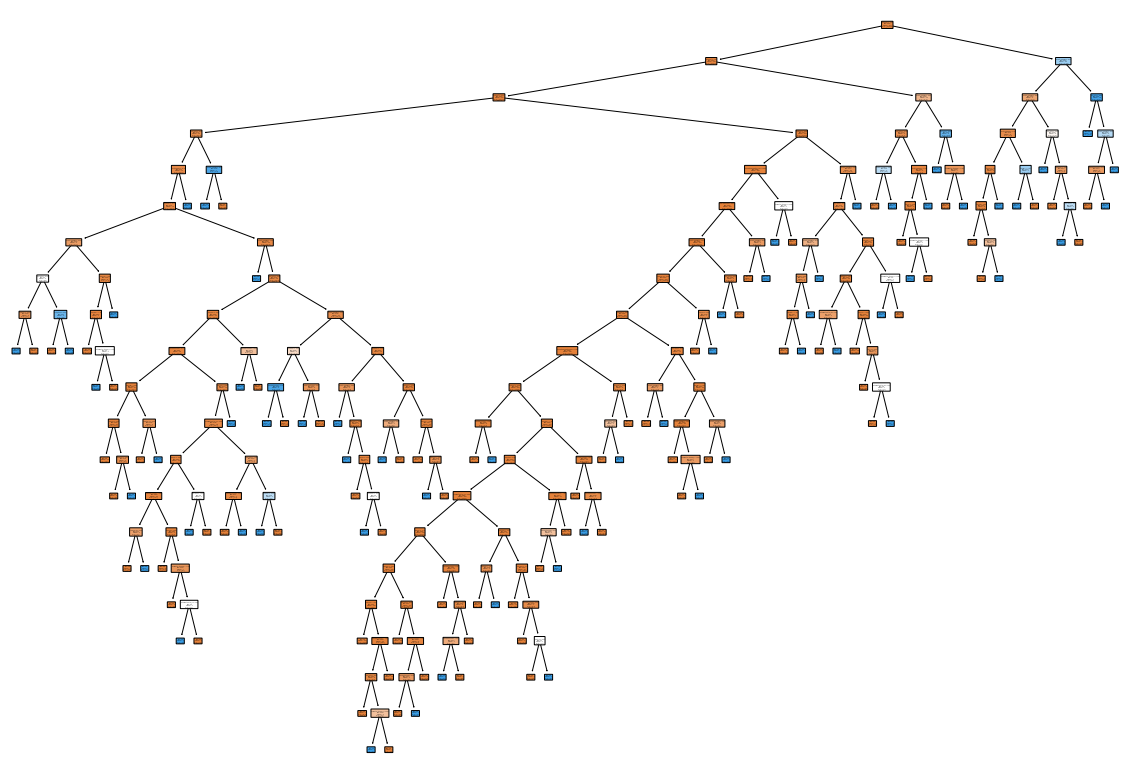

In [59]:
#Create the tree plot

plt.figure(figsize=(20,14))
plot_tree(dTree,
           feature_names = k_X_test.columns, #Feature names
           class_names = ["0","1"], #Class names
           rounded = True,
           filled = True)

# leaving this in for now even though it's inelligible
plt.savefig('dTree.png')
plt.show()

### Punts

In [60]:
p_X_train, p_X_test, p_y_train, p_y_test = process_for_modelling(process_punts(punts), 'penaltyFlag')

In [61]:
p_X_train

,yardsToGo,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,yardsFromEndzone,snapTime,operationTime,hangTime,gunners,puntRushers,specialTeamsSafeties,vises,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,team_ARI,team_ATL,team_BAL,team_BUF,team_CAR,team_CHI,team_CIN,team_CLE,team_DAL,team_DEN,team_DET,team_GB,team_HOU,team_IND,team_JAX,team_KC,team_LA,team_LAC,team_LV,team_MIA,team_MIN,team_NE,team_NO,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,result_Blocked Punt,result_Downed,result_Fair Catch,result_Muffed,result_Non-Special Teams Result,result_Out of Bounds,result_Return,result_Touchback,snap_<,snap_>,snap_H,snap_L,snap_OK,kickDirectionIntended_C,kickDirectionIntended_L,kickDirectionIntended_R,kickDirectionActual_C,kickDirectionActual_L,kickDirectionActual_R,returnDirectionIntended_C,returnDirectionIntended_L,returnDirectionIntended_R,returnDirectionActual_C,returnDirectionActual_L,returnDirectionActual_R,kickContactType_BB,kickContactType_BC,kickContactType_BF,kickContactType_BOG,kickContactType_CC,kickContactType_CFFG,kickContactType_DEZ,kickContactType_ICC,kickContactType_KTB,kickContactType_KTC,kickContactType_KTF,kickContactType_MBC,kickContactType_MBDR,kickContactType_OOB,typeOfKick_A,typeOfKick_N,typeOfKick_R
0,-0.694126,-0.805833,0.731495,-0.409659,0.796420,-0.827125,1.002428,0.458029,-1.525141,0.168590,-0.001373,-0.669272,0.703994,-0.658179,-0.583580,1.600085,-0.551108,-0.540921,-0.076045,-0.195573,-0.168734,-0.168066,-0.180393,-0.178497,-0.179763,-0.187204,-0.179763,-0.166721,-0.194986,-0.180393,-0.177861,-0.173351,-0.166046,-0.195573,-0.145229,-0.175940,-0.161938,-0.077449,-0.195573,-0.168734,-0.180393,-0.163317,-0.189627,-0.212559,-0.157734,-0.182273,-0.183516,-0.184752,-0.176582,5.973902,-0.184135,-0.193214,0.0,-0.403673,-0.614435,-0.163317,0.0,-0.32874,1.227139,-0.259837,-0.109859,-0.108862,-0.142919,-0.177223,0.282908,-0.937230,-0.655716,1.826500,1.01805,-0.635190,-0.531704,2.328965,-0.305139,-0.331516,2.409522,-0.315449,-0.337420,-0.237129,-0.0654,-0.464366,-0.025283,0.747382,-0.161244,-0.101622,-0.054682,-0.062031,-0.074615,-0.04382,-0.038637,-0.160547,-0.220641,1.526596,-1.525051,-0.020642
1,0.486711,-0.388681,0.312389,-0.971965,-0.434244,-0.374497,1.362299,-0.827243,0.187406,-0.207241,-0.001373,-0.669272,-0.670052,-0.658179,-0.583580,1.600085,-0.551108,-0.540921,-0.076045,-0.195573,-0.168734,-0.168066,-0.180393,-0.178497,-0.179763,-0.187204,-0.179763,-0.166721,-0.194986,-0.180393,-0.177861,-0.173351,-0.166046,-0.195573,-0.145229,-0.175940,-0.161938,-0.077449,-0.195573,-0.168734,-0.180393,-0.163317,-0.189627,-0.212559,-0.157734,-0.182273,-0.183516,-0.184752,-0.176582,-0.167395,5.430792,-0.193214,0.0,-0.403673,1.627512,-0.163317,0.0,-0.32874,-0.814904,-0.259837,-0.109859,-0.108862,-0.142919,-0.177223,0.282908,-0.937230,1.525051,-0.547495,-0.98227,1.574331,-0.531704,-0.429375,-0.305139,-0.331516,-0.415020,-0.315449,-0.337420,-0.237129,-0.0654,-0.464366,-0.025283,0.747382,-0.161244,-0.101622,-0.054682,-0.062031,-0.074615,-0.04382,-0.038637,-0.160547,-0.220641,1.526596,-1.525051,-0.020642
2,-1.200198,-0.805833,-1.049707,0.714952,-0.188111,0.802335,-0.149160,-0.345266,-0.954292,-0.052487,-0.001373,0.342283,-0.670052,-0.658179,1.713562,-0.624967,-0.551108,-0.540921,-0.076045,-0.195573,-0.168734,-0.168066,-0.180393,-0.178497,-0.179763,-0.187204,-0.179763,-0.166721,5.128579,-0.180393,-0.177861,-0.173351,-0.166046,-0.195573,-0.145229,-0.175940,-0.161938,-0.077449,-0.195573,-0.168734,-0.180393,-0.163317,-0.189627,-0.212559,-0.157734,-0.182273,-0.183516,-0.184752,-0.176582,-0.167395,-0.184135,-0.193214,0.0,-0.403673,-0.614435,-0.163317,0.0,-0.32874,1.227139,-0.259837,-0.109859,-0.108862,-0.142919,-0.177223,0.282908,-0.937230,1.525051,-0.547495,-0.98227,1.574331,-0.531704,-0.429375,-0.305139,-0.331516,-0.415020,-0.315449,-0.337420,-0.237129,-0.0654,-0.464366,-0.025283,0.747382,-0.161244,-0.101622,-0.054682,-0.062031,-0.074615,-0.04382,-0.038637

In [62]:
p_X_train.describe()

,yardsToGo,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,yardsFromEndzone,snapTime,operationTime,hangTime,gunners,puntRushers,specialTeamsSafeties,vises,quarter_1,quarter_2,quarter_3,quarter_4,quarter_5,team_ARI,team_ATL,team_BAL,team_BUF,team_CAR,team_CHI,team_CIN,team_CLE,team_DAL,team_DEN,team_DET,team_GB,team_HOU,team_IND,team_JAX,team_KC,team_LA,team_LAC,team_LV,team_MIA,team_MIN,team_NE,team_NO,team_NYG,team_NYJ,team_OAK,team_PHI,team_PIT,team_SEA,team_SF,team_TB,team_TEN,team_WAS,result_Blocked Punt,result_Downed,result_Fair Catch,result_Muffed,result_Non-Special Teams Result,result_Out of Bounds,result_Return,result_Touchback,snap_<,snap_>,snap_H,snap_L,snap_OK,kickDirectionIntended_C,kickDirectionIntended_L,kickDirectionIntended_R,kickDirectionActual_C,kickDirectionActual_L,kickDirectionActual_R,returnDirectionIntended_C,returnDirectionIntended_L,returnDirectionIntended_R,returnDirectionActual_C,returnDirectionActual_L,returnDirectionActual_R,kickContactType_BB,kickContactType_BC,kickContactType_BF,kickContactType_BOG,kickContactType_CC,kickContactType_CFFG,kickContactType_DEZ,kickContactType_ICC,kickContactType_KTB,kickContactType_KTC,kickContactType_KTF,kickContactType_MBC,kickContactType_MBDR,kickContactType_OOB,typeOfKick_A,typeOfKick_N,typeOfKick_R
count,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4696.0,4.696000e+03,4.696000e+03,4.696000e+03,4696.0,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03,4.696000e+03
mean,3.529734e-17,1.740043e-16,-8.584369e-17,-1.489557e-16,-5.042342e-16,5.403235e-16,1.151005e-16,8.058101e-16,-4.042503e-15,1.462487e-16,-2.266025e-15,1.624670e-16,-4.592200e-16,-8.130445e-16,-1.775506e-16,-2.434642e-16,-7.502044e-16,5.131235e-16,4.474227e-16,-8.505169e-17,6.395130e-18,-1.235667e-15,-6.544665e-16,4.735352e-16,2.291254e-16,1.168264e-16,1.833547e-16,-1.473481e-16,1.150934e-15,-6.678479e-16,1.087621e-15,1.324324e-15,1.173950e-15,-6.948942e-16,-1.347989e-15,1.288116e-15,2.080486e-18,-1.490503e-16,-2.504149e-16,9.056025e-17,-7.081809e-16,4.782163e-16,-1.576677e-15,3.813082e-16,-9.884555e-16,8.331401e-16,2.641390e-16,3.871714e-16,8.312960e-16,3.712367e-16,-1.202781e-16,-1.998922e-17,0.0,-4.688895e-16,1.473835e-16,4.317954e-16,0.0,-1.500409e-15,7.478875e-16,-3.828922e-16,4.411162e-16,1.289393e-15,-1.732477e-16,-2.954290e-16,2.507931e-16,4.597874e-16,-3.394975e-17,-8.660496e-16,-2.909843e-16,-1.667226e-16,5.276869e-16,2.416390e-15,5.118469e-17,4.144423e-17,-1.087740e-15,-1.001683e-15,1.660843e-16,-8.227259e-16,1.261058e-16,-1.499250e-16,6.563889e-16,3.336343e-16,2.314186e-16,-5.441771e-17,8.050033e-16,2.610862e-16,4.190761e-16,-2.323111e-17,8.755507e-16,-5.674053e-19,3.215651e-16,1.207628e-16,-2.558052e-17,-1.522840e-15
std,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.000106e+00,1.00010

In [63]:
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    #"Logistic Regression": LogisticRegression(),
    "Stochastic Gradient Descent Classifier": SGDClassifier(),
    "Support Vector Classifier": SVC(),
    "Linear Support Vector Classifier": LinearSVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifer": RandomForestClassifier()         
         }

In [64]:
# train
for name, model in models.items():
    model.fit(p_X_train, p_y_train)
    print(name + " trained.")

K-Nearest Neighbors trained.
Stochastic Gradient Descent Classifier trained.
Support Vector Classifier trained.


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear Support Vector Classifier trained.
Decision Tree Classifier trained.
Random Forest Classifer trained.


In [65]:
for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(p_X_test, p_y_test)))

K-Nearest Neighbors R^2 Score: 0.88936
Stochastic Gradient Descent Classifier R^2 Score: 0.93787
Support Vector Classifier R^2 Score: 0.89362
Linear Support Vector Classifier R^2 Score: 0.89872
Decision Tree Classifier R^2 Score: 0.92340
Random Forest Classifer R^2 Score: 0.91574
